In [124]:
%run functions.py
% run archive/silhouette_plotter.py

In [125]:
table = 'eth-tokens.test.clean_avg_with_balances_tokens'
label_table = 'eth-tokens.alldata.etherscan_labelcloud'

In [126]:
df, dflabel = load_data_from_bigquery(table, label_table)

In [127]:
results = data_pipeline(df)

In [128]:
# #trying out feature scaling to see if we get better separation
# df['incoming_std_time_btwn_txns'] = df['incoming_std_time_btwn_txns']/df['incoming_avg_time_btwn_txns']
# df['outgoing_std_time_btwn_txns'] = df['outgoing_std_time_btwn_txns']/df['outgoing_avg_time_btwn_txns']
# results = data_pipeline(df)

In [129]:
cl = cluster(results, n_clusters=8)

In [130]:
assign_cluster_to_data(df, dflabel, cl)

In [131]:
tsne_results = calc_tsne(results, perplexity=50,n_iter=250)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 35917 samples in 0.024s...
[t-SNE] Computed neighbors for 35917 samples in 11.181s...
[t-SNE] Computed conditional probabilities for sample 1000 / 35917
[t-SNE] Computed conditional probabilities for sample 2000 / 35917
[t-SNE] Computed conditional probabilities for sample 3000 / 35917
[t-SNE] Computed conditional probabilities for sample 4000 / 35917
[t-SNE] Computed conditional probabilities for sample 5000 / 35917
[t-SNE] Computed conditional probabilities for sample 6000 / 35917
[t-SNE] Computed conditional probabilities for sample 7000 / 35917
[t-SNE] Computed conditional probabilities for sample 8000 / 35917
[t-SNE] Computed conditional probabilities for sample 9000 / 35917
[t-SNE] Computed conditional probabilities for sample 10000 / 35917
[t-SNE] Computed conditional probabilities for sample 11000 / 35917
[t-SNE] Computed conditional probabilities for sample 12000 / 35917
[t-SNE] Computed conditional probabilities for s

/home/ubuntu/ethereum_clustering/functions.py:97: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


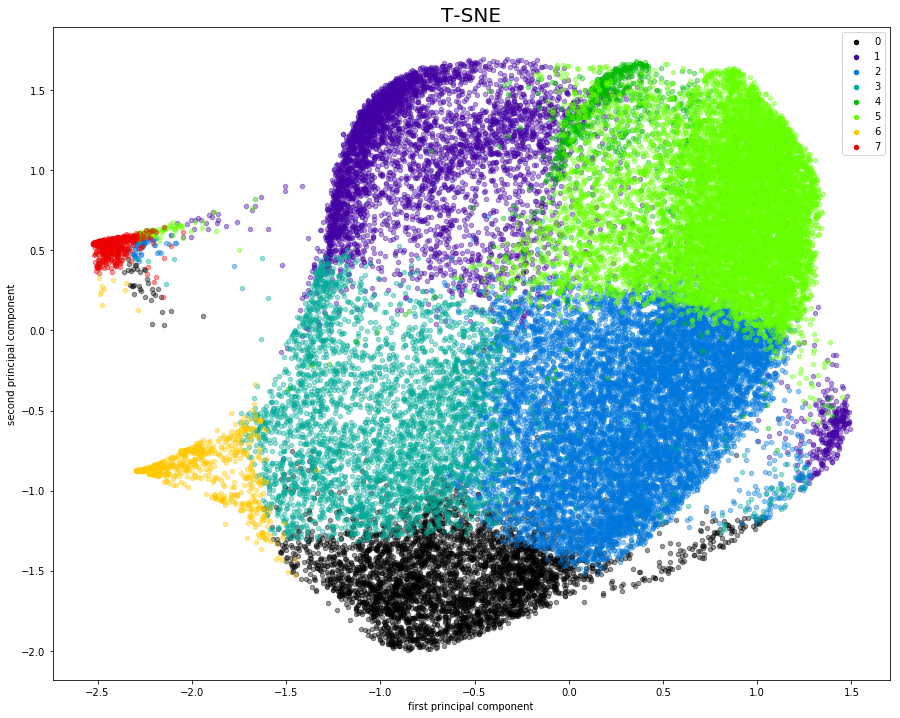

In [132]:
plot_tsne(cl, tsne_results)

In [133]:
#highlighting clusters of interest
categs = ('Exchange', 'Mining', 'ICO Wallets')
colors = ('green', 'blue', 'orange')

d = {}
for c in categs:
    d[c] = find_category_of_cluster(cl,dflabel, category=c)

clusters= list(d.values())

Exchange
cluster number   0   number of type found: 2    cluster size: 4091   label density: 0.0004888780249327792
cluster number   1   number of type found: 0    cluster size: 4827   label density: 0.0
cluster number   2   number of type found: 0    cluster size: 10916   label density: 0.0
cluster number   3   number of type found: 1    cluster size: 3525   label density: 0.00028368794326241134
cluster number   4   number of type found: 0    cluster size: 940   label density: 0.0
cluster number   5   number of type found: 0    cluster size: 10580   label density: 0.0
cluster number   6   number of type found: 45    cluster size: 640   label density: 0.0703125
cluster number   7   number of type found: 5    cluster size: 398   label density: 0.01256281407035176
Mining
cluster number   0   number of type found: 0    cluster size: 4091   label density: 0.0
cluster number   1   number of type found: 0    cluster size: 4827   label density: 0.0
cluster number   2   number of type found: 0 

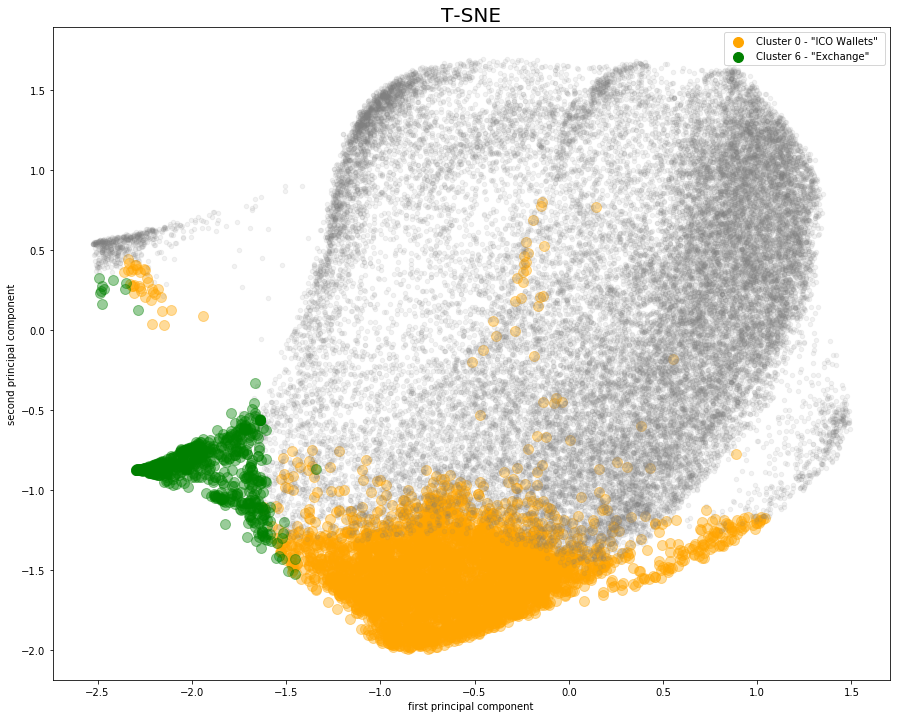

In [134]:
plot_tsne_with_labeled_clusters(tsne_results, cl, clusters, categs, colors)

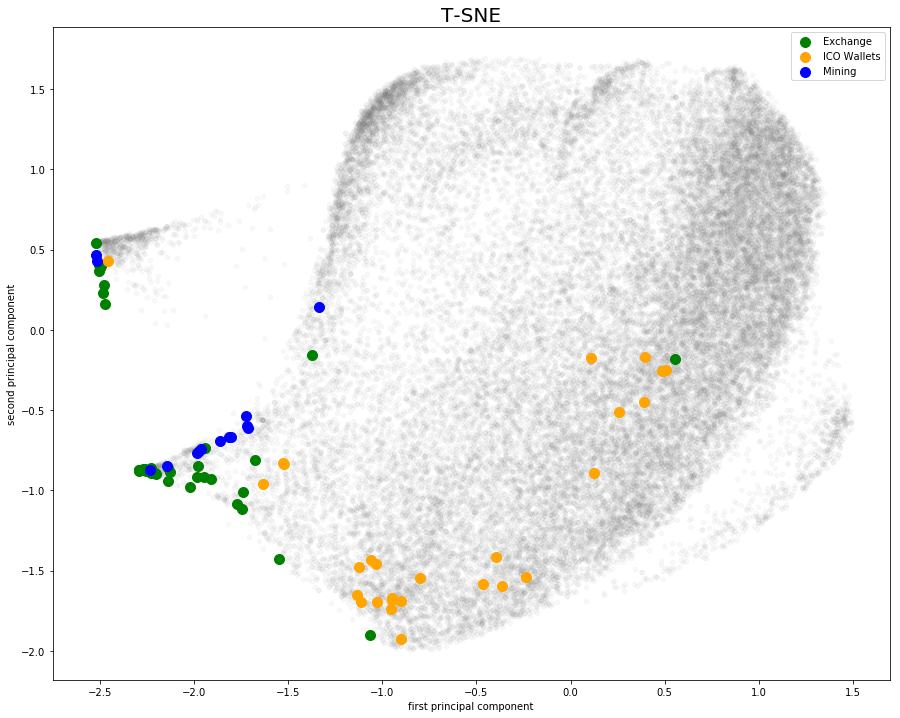

In [135]:
plot_tsne_with_labels(tsne_results,df, dflabel,categs,colors)

In [136]:
#highlighting clusters of interest
categs = ('Exchange', 'Mining')#, 'ICO Wallets')
colors = ('green', 'blue')#, 'orange')

d = {}
for c in categs:
    d[c] = find_category_of_cluster(cl,dflabel, category=c)

clusters= list(d.values())

Exchange
cluster number   0   number of type found: 2    cluster size: 4091   label density: 0.0004888780249327792
cluster number   1   number of type found: 0    cluster size: 4827   label density: 0.0
cluster number   2   number of type found: 0    cluster size: 10916   label density: 0.0
cluster number   3   number of type found: 1    cluster size: 3525   label density: 0.00028368794326241134
cluster number   4   number of type found: 0    cluster size: 940   label density: 0.0
cluster number   5   number of type found: 0    cluster size: 10580   label density: 0.0
cluster number   6   number of type found: 45    cluster size: 640   label density: 0.0703125
cluster number   7   number of type found: 5    cluster size: 398   label density: 0.01256281407035176
Mining
cluster number   0   number of type found: 0    cluster size: 4091   label density: 0.0
cluster number   1   number of type found: 0    cluster size: 4827   label density: 0.0
cluster number   2   number of type found: 0 

In [137]:
#recluster with only clusters of interest - will help with separation

subcl, subresults, newdf = recluster(df, cl, clusters, n_clusters=3)

In [138]:
sub_tsne_results = calc_tsne(subresults)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 640 samples in 0.000s...
[t-SNE] Computed neighbors for 640 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 640 / 640
[t-SNE] Mean sigma: 1.485581
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.710758
[t-SNE] KL divergence after 300 iterations: 0.789849
t-SNE done! Time elapsed: 1.2750027179718018 seconds


In [139]:
assign_cluster_to_data(newdf, dflabel, subcl)

In [140]:
#highlighting clusters of interest

d = {}
for c in categs:
    d[c] = find_category_of_cluster(subcl,dflabel, category=c)

subclusters= list(d.values())

Exchange
cluster number   0   number of type found: 33    cluster size: 151   label density: 0.2185430463576159
cluster number   1   number of type found: 8    cluster size: 181   label density: 0.04419889502762431
cluster number   2   number of type found: 4    cluster size: 308   label density: 0.012987012987012988
Mining
cluster number   0   number of type found: 2    cluster size: 151   label density: 0.013245033112582781
cluster number   1   number of type found: 0    cluster size: 181   label density: 0.0
cluster number   2   number of type found: 9    cluster size: 308   label density: 0.02922077922077922


/home/ubuntu/ethereum_clustering/functions.py:97: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


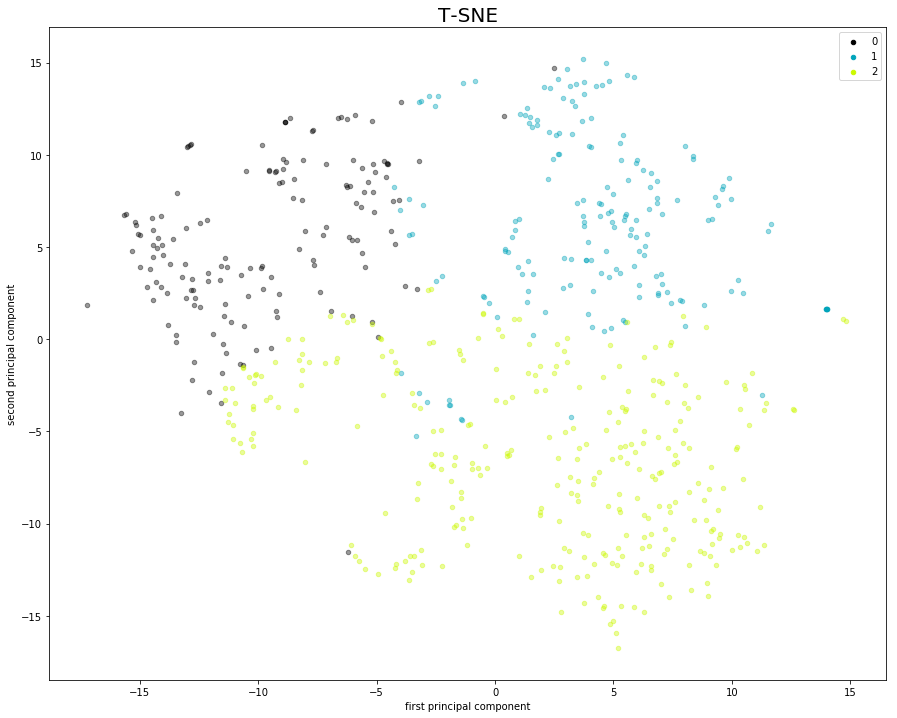

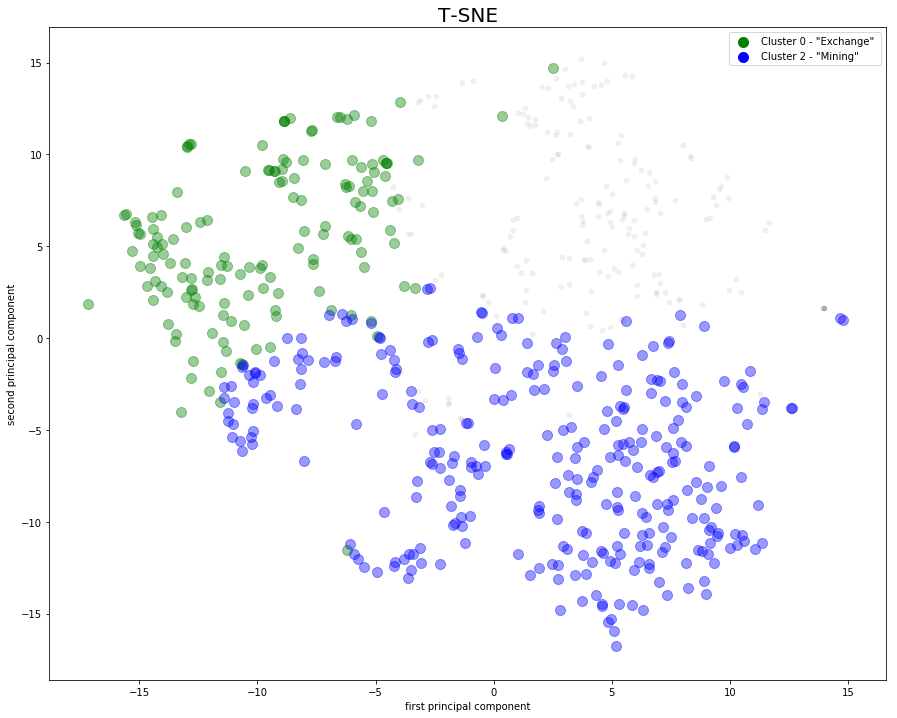

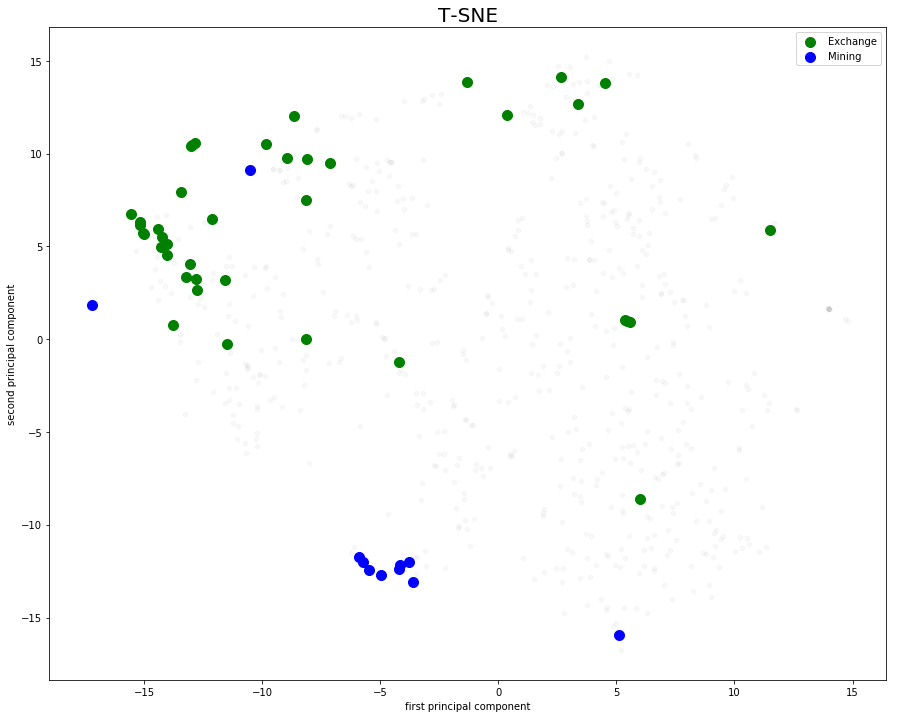

In [141]:
plot_all(sub_tsne_results,subcl,newdf,dflabel,subclusters,categs,colors )


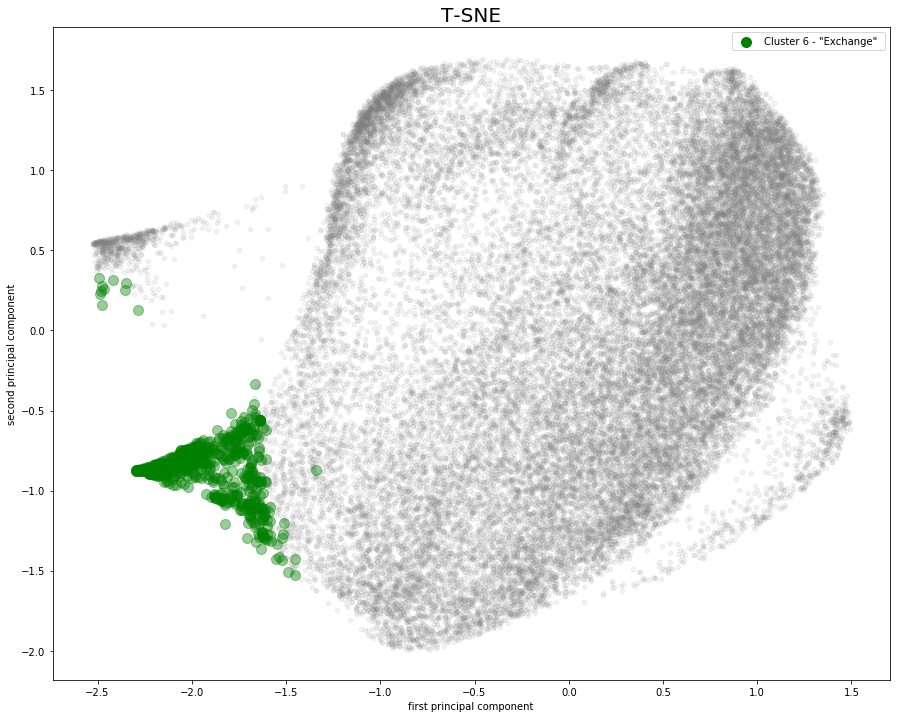

In [142]:
plot_tsne_with_labeled_clusters(tsne_results, cl, clusters, categs, colors)

In [172]:
%run supervised.py

In [173]:
dflabel.shape

(126, 29)

/home/ubuntu/ethereum_clustering/supervised.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X.drop('cluster', axis=1, inplace=True)


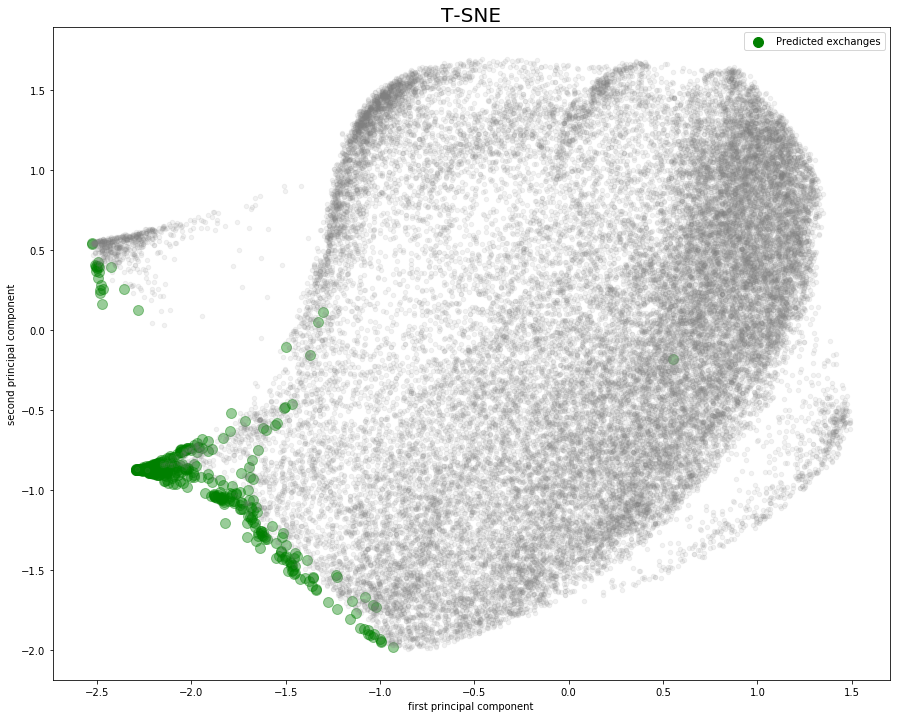

In [181]:
target = "Exchange"
predictions = get_predictions(df, dflabel, target)

plot_predictions(tsne_results,predictions)

/home/ubuntu/ethereum_clustering/supervised.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X.drop('cluster', axis=1, inplace=True)


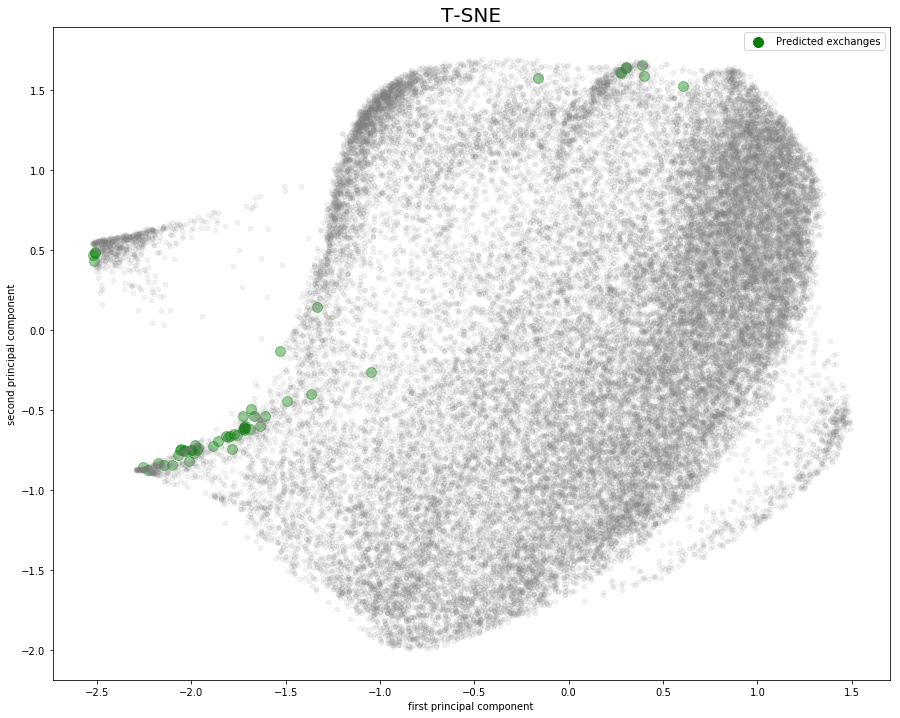

In [182]:
target = "Mining"
predictions = get_predictions(df, dflabel, target)

plot_predictions(tsne_results,predictions)

/home/ubuntu/ethereum_clustering/supervised.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X.drop('cluster', axis=1, inplace=True)


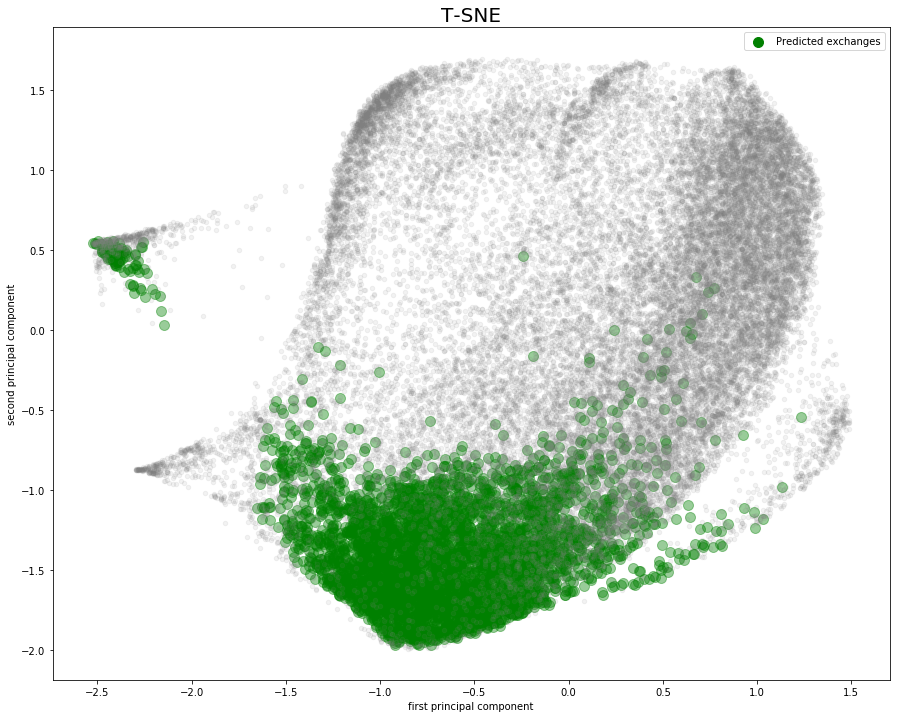

In [183]:
target = "ICO Wallets"
predictions = get_predictions(df, dflabel, target)

plot_predictions(tsne_results,predictions)